### Imports 

In [2]:
import sys
import imp
import numpy as np
import glob

sys.path.append('./')

import modeling_pymc3_data_functions
imp.reload(modeling_pymc3_data_functions)
from modeling_pymc3_data_functions import load_dataset,load_data
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import seaborn as sns
from exclude import EXCLUDE_PAIN
from scipy.stats import pearsonr,spearmanr,ttest_1samp

In [3]:
sys.path.append('/Users/chris/anaconda/envs/env_pymc3/lib/python3.6/')
sys.path.append('/Users/chris/anaconda/envs/env_pymc3/lib/python3.6/site-packages/')
import pymc3 as pm
import theano
import theano.tensor as T

### Load Data

In [4]:
task='pain'
folders = ['data/data_raw_clinical_dm/','data/data_raw_mikes_fmri/']

out = load_dataset(task,
                   folders,
                   mask=False,
                   how_many='all',
                   #how_many=3,
                  exclude=[])

outcomes=out['outcomes']
mag_1=out['mag_1']
mag_0=out['mag_0']
participants_choices=out['participants_choices']
outcomes_del=out['outcomes_del']
vols = out['vols']
vols = vols-np.mean(vols,axis=0) # subtract out mean 

In [5]:
participants_choices

array([[ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 1.,  1.,  0., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  1.,  0.,  1.],
       ..., 
       [ 1.,  0.,  1., ...,  0.,  0.,  1.],
       [ 1.,  0.,  1., ...,  0.,  1.,  1.],
       [ 0.,  0.,  1., ...,  0.,  1.,  0.]])

In [6]:
participants_choices.shape

(180, 86)

In [7]:
MIDS=list(out['MIDS'])
MIDS[0:5]

['cb25', 'cb74', 'cb75', 'cb76', 'cb77']

In [8]:
outcomes_del.shape

(180, 86)

In [9]:
vols.shape

(180, 86)

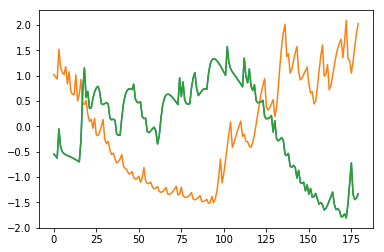

In [10]:
plt.plot(vols[:,0])
plt.plot(vols[:,1])
plt.plot(vols[:,2])

### Defining Model

In [11]:
###################################
### Core functions (in theano) ####

# calculate lr 

def update_estimate(next_outcome, lr,estimate_so_far):
    return lr*(next_outcome-estimate_so_far)+estimate_so_far

def calc_prob_choice(estimate_r_t,
                     mag_1_t,mag_0_t,
                     Bm,Bp):
    choice_value = Bm*(mag_1_t-mag_0_t) + Bp*(estimate_r_t-(1.0-estimate_r_t))
    return(1.0/(1+T.exp(-1.0*choice_value)))



In [12]:
with pm.Model() as model:

    # input variables (become T.Constants)
    outcomes_t=T.as_tensor_variable(outcomes)
    mag_1_t = T.as_tensor_variable(mag_1)
    mag_0_t = T.as_tensor_variable(mag_0)
    outcomes_del_t = T.as_tensor_variable(outcomes_del)
    vol_t = T.as_tensor_variable(vols)
    
    N = outcomes.shape[1] # N participants
    
    # learning rates 
    #learning_rate_baseline_t = pm.Uniform('learning_rate_baseline_t',lower=0,upper=1,shape=(N))
    learning_rate_baseline_t = pm.Bound(pm.Normal,lower=0,upper=1)('learning_rate_baseline_t',mu=0.2,sd=.5,shape=(N))
    learning_rate_baseline_t_tiled = T.reshape(T.tile(learning_rate_baseline_t,180),(180,N))
    
    # learning rate outcome 
    learning_rate_outcome_t = pm.Bound(pm.Normal,lower=-1,upper=1)('learning_rate_outcome_t',mu=0.0,sd=.5,shape=(N))
    #learning_rate_outcome_t = pm.Normal('learning_rate_outcome_t',mu=0,sd=0.5,shape=(N))
    learning_rate_outcome_t_tiled = T.reshape(T.tile(learning_rate_outcome_t,180),(180,N))

    # learning rate vol 
    learning_rate_vol_t = pm.Bound(pm.Normal,lower=-1,upper=1)('learning_rate_vol_t',mu=0.0,sd=.5,shape=(N))
    learning_rate_vol_t_tiled = T.reshape(T.tile(learning_rate_vol_t,180),(180,N))

    learning_rate_tiled_combined_t = learning_rate_baseline_t_tiled + \
        learning_rate_outcome_t_tiled*outcomes_del_t + \
        learning_rate_vol_t_tiled*vol_t
    
    learning_rate_tiled_combined_t = pm.Deterministic('learning_rate_tiled_combined_t',learning_rate_tiled_combined_t)
    
    p_min_learning_rate = pm.Potential('p_min_learning_rate', 
                                           T.switch(learning_rate_tiled_combined_t < .01, 
                                                         -np.inf, 
                                                         0))
    
    p_max_learning_rate = pm.Potential('p_max_learning_rate', 
                                           T.switch(learning_rate_tiled_combined_t > 1.0, 
                                                         -np.inf, 
                                                         0))
    
    
    # Bm
    Bm_t = pm.Normal('Bm_t',mu=0,sd=1,shape=(N))
    
    # Bp
    Bp_t = pm.Normal('Bp_t',mu=0,sd=1,shape=(N))
    

    starting_belief_t = T.ones_like(learning_rate_baseline_t)*0.5

    # adjust baseline learning rate    
    def update_estimate(next_outcome, lr, estimate_so_far):
        return lr * (next_outcome - estimate_so_far) + estimate_so_far

    estimate_r_t, _ = theano.scan(fn=update_estimate,
                                  sequences=[outcomes_t, learning_rate_tiled_combined_t],
                                  outputs_info=starting_belief_t)
    
    # shift estimates and put the starting belief into the matrix.
    estimate_r_t = T.roll(estimate_r_t,axis=0,shift=1)
    estimate_r_t =T.set_subtensor(estimate_r_t[0,:],starting_belief_t)

    prob_choice_t = calc_prob_choice(estimate_r_t,
                                            mag_1_t,
                                            mag_0_t,
                                            Bm_t,
                                            Bp_t)
    
    observed_choice = pm.Bernoulli('observed_choice',p=prob_choice_t,
                                          observed=participants_choices)


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '17839' (I am process '17917')


### Fitting Model

In [13]:
with model:
    step = pm.NUTS()
    trace_group = pm.sample(2000,step=step,chains=2,)
    ppc_group = pm.sample_ppc(trace_group,samples=500)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Bp_t, Bm_t, learning_rate_vol_t_interval__, learning_rate_outcome_t_interval__, learning_rate_baseline_t_interval__]
100%|██████████| 2500/2500 [03:17<00:00, 12.67it/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.712614564461, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 500/500 [00:06<00:00, 72.01it/s]


In [14]:
#pm.traceplot(trace_group)

### Save Model

In [19]:
# import pickle
# with open('./model_fits_pymc3/6_28_18_mag_prob_model_w_alpha_vol_alpha_outcome_and_trace_pain_cdm.pkl', "wb" ) as buff:
#     pickle.dump({'model': model, 'trace': trace_group, 'ppc': ppc_group}, buff)

### Load Model

In [20]:
# import pickle
# with open('./model_fits_pymc3/6_28_18_mag_prob_model_w_alpha_vol_alpha_outcome_and_trace_pain_cdm.pkl', "rb" ) as buff:
#     model_output = pickle.load(buff)
# trace_group=model_output['trace']
# ppc_group=model_output['ppc']